# AI Tools for Actuaries
## Chapter 5: LocalGLMnet in Python
### Author: Mario Wuthrich
### Version April 2025

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import pyreadr
from statsmodels.formula.api import glm
import statsmodels.api as sm
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt

# Set random seed
np.random.seed(500)

### Load data

In [2]:
# Load the data (load the data with the entity embeddings)
dat = pyreadr.read_r('../../Data/freMTPL2freqEmb.rda')  # load the data
dat = dat[None] if None in dat else dat[list(dat.keys())[0]]

### Pre-process data for LocalGLMnet

In [3]:
# Pre-process the data for network
def preprocess_continuous(var1, dat2):
    dat2[var1] = pd.to_numeric(dat2[var1])
    dat2[f"{var1}X"] = (dat2[var1] - dat2[var1].mean()) / dat2[var1].std()
    return dat2

def features_preprocess(dat2):
    dat2 = dat2.copy() 
    # Convert categorical variables to numeric first
    area_mapping = {cat: i for i, cat in enumerate(dat2["Area"].unique())}
    dat2["Area"] = pd.to_numeric(dat2["Area"].map(area_mapping))
    dat2 = preprocess_continuous("Area", dat2)
    dat2 = preprocess_continuous("VehPower", dat2)
    dat2["VehAge"] = dat2["VehAge"].clip(upper=20)
    dat2 = preprocess_continuous("VehAge", dat2)
    dat2["DrivAge"] = dat2["DrivAge"].clip(upper=90)
    dat2 = preprocess_continuous("DrivAge", dat2)
    dat2["BonusMalus"] = dat2["BonusMalus"].clip(upper=150)
    dat2 = preprocess_continuous("BonusMalus", dat2)
    dat2 = preprocess_continuous("VehBrandEmb1", dat2)
    dat2 = preprocess_continuous("VehBrandEmb2", dat2)
    gas_mapping = {cat: i for i, cat in enumerate(dat2["VehGas"].unique())}
    dat2["VehGasX"] = pd.to_numeric(dat2["VehGas"].map(gas_mapping))
    dat2["Density"] = np.log(dat2["Density"]).round(2)
    dat2 = preprocess_continuous("Density", dat2)
    dat2 = preprocess_continuous("RegionEmb1", dat2)
    dat2 = preprocess_continuous("RegionEmb2", dat2)
    return dat2
# Pre-process data
dat2 = features_preprocess(dat)

# Add random component
np.random.seed(500)
dat2['RandN'] = np.random.normal(0, 1, size=len(dat2))
dat2['RandNX'] = dat2['RandN']


# Split data (this uses the same split and order as in Wuthrich-Merz (Springer 2023))
learn = dat2[dat2['LearnTest'] == 'L'].copy()
test = dat2[dat2['LearnTest'] == 'T'].copy()

print(f"Learning set size: {len(learn)}")
print(f"Test set size: {len(test)}")

# Display data structure
# print(dat2.info())

Learning set size: 610206
Test set size: 67801


### GLM baseline analysis

In [4]:
# We start with a baseline GLM to initialize the LocalGLMnet suitably

# Features
features = ['AreaX', 'VehPowerX', 'VehAgeX', 'DrivAgeX', 'BonusMalusX',
           'VehGasX', 'DensityX', 'VehBrandEmb1X', 'VehBrandEmb2X', 'RegionEmb1X', 'RegionEmb2X', 'RandNX']

# Fit GLM
model = glm("ClaimNb ~ AreaX + VehPowerX + VehAgeX + DrivAgeX + BonusMalusX + VehGasX + DensityX + VehBrandEmb1X + VehBrandEmb2X + RegionEmb1X + RegionEmb2X + RandNX",
            data=learn,
            offset=np.log(learn['Exposure']),
            family=sm.families.Poisson())

glm_results = model.fit()

# Display model summary
print(glm_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                ClaimNb   No. Observations:               610206
Model:                            GLM   Df Residuals:                   610193
Model Family:                 Poisson   Df Model:                           12
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -96588.
Date:                Tue, 29 Apr 2025   Deviance:                   1.4752e+05
Time:                        14:45:07   Pearson chi2:                 1.03e+06
No. Iterations:                     7   Pseudo R-squ. (CS):            0.01032
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -2.7536      0.010   -279.919

### Calculate deviance losses

In [5]:
from sklearn.metrics import mean_poisson_deviance

# Get predictions
learn['GLM'] = glm_results.predict(learn)
test['GLM'] = glm_results.predict(test)

# Calculate in-sample and out-of-sample deviance
learn_deviance = 100*mean_poisson_deviance(learn['ClaimNb']/learn['Exposure'], learn['GLM'], sample_weight=learn['Exposure'])
test_deviance = 100*mean_poisson_deviance(test['ClaimNb']/test['Exposure'], test['GLM'], sample_weight=test['Exposure'])

print("Deviance Losses:")
print(f"Learning sample: {learn_deviance:.3f}")
print(f"Test sample: {test_deviance:.3f}")

Deviance Losses:
Learning sample: 45.759
Test sample: 45.634


## LocalGLMnet
We have performed all the preparatory work above, and now we dive into the LocalGLMnet

### Define the LocalGLMnet arichtecture (of depth 3)

In [6]:
def create_LocalGLMnet(seed, q0):
    tf.keras.backend.clear_session()
    tf.random.set_seed(seed)
    
    # Input layers
    design = keras.layers.Input(shape=(q0[0],), dtype='float32')
    volume = keras.layers.Input(shape=(1,), dtype='float32')

    # Attention mechanism
    attention = design
    attention = keras.layers.Dense(q0[1], activation='tanh')(attention)
    attention = keras.layers.Dense(q0[2], activation='tanh')(attention)
    attention = keras.layers.Dense(q0[3], activation='tanh')(attention)
    attention = keras.layers.Dense(q0[0], activation='linear', name='Attention')(attention)
     
    # Local GLM operation
    local_glm = keras.layers.Dot(axes=1)([design, attention])
    local_glm = keras.layers.Dense(1, activation='exponential')(local_glm)
    
    # Combine with volume
    output = keras.layers.Multiply()([local_glm, volume])
    
    model = keras.Model(inputs=[design, volume], outputs=output)
    return model


### Prepare the features and introduce the LocalGLMnet

In [8]:
q0 = len(features)

# Prepare matrices
X_learn = learn[features].astype('float32').values
X_test = test[features].astype('float32').values
# Exposure
V_learn = learn['Exposure'].astype('float32').values.reshape(-1, 1)
V_test = test['Exposure'].astype('float32').values.reshape(-1, 1)
# Response
Y_learn = learn['ClaimNb'].astype('float32').values.reshape(-1, 1)
Y_test = test['ClaimNb'].astype('float32').values.reshape(-1, 1)

# Define network architecture
q00 = [q0, 20, 15, 10]

seed = 100

# Create model
model = create_LocalGLMnet(seed, q00)


model.summary()



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 12)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 20)        │        260 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 15)        │        315 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 10)        │        160 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Attention (Dense)   │ (None, 12)        │        132 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot (Dot)           │ (None, 1)         │          0 │ input_layer[0][0… │
│                     │                   │            │ Attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │          2 │ dot[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply (Multiply) │ (None, 1)         │          0 │ dense_3[0][0],    │
│                     │                   │            │ input_layer_1[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 869 (3.39 KB)

 Trainable params: 869 (3.39 KB)

 Non-trainable params: 0 (0.00 B)

### Initialize the LocalGLMnet to the previously fitted GLM

In [19]:
### Initialize the LocalGLMnet to the previously fitted GLM
weights = model.get_weights()
weights[-1] = np.array([glm_results.params.iloc[0]])  # Use statsmodels intercept
weights[-2] = np.ones_like(weights[-2])
weights[-4] = np.zeros_like(weights[-4])
coefficients = glm_results.params.iloc[1:] 
for i, coef in enumerate(coefficients):#
    weights[-3][i] = coef
model.set_weights(weights)


# Backtest the initalization
test_GLM = model.predict([X_test, V_test], batch_size=10**6, verbose=0)
learn_GLM = model.predict([X_learn, V_learn], batch_size=10**6, verbose=0)

print("Poisson Deviance (Train, Test):", 
      round(100*mean_poisson_deviance(Y_learn/V_learn, learn_GLM/V_learn, sample_weight=V_learn), 3),
      round(100*mean_poisson_deviance(Y_test/V_test, test_GLM/V_test, sample_weight=V_test), 3))


Poisson Deviance (Train, Test): 45.759 45.634


### Train the LocalGLMnet model

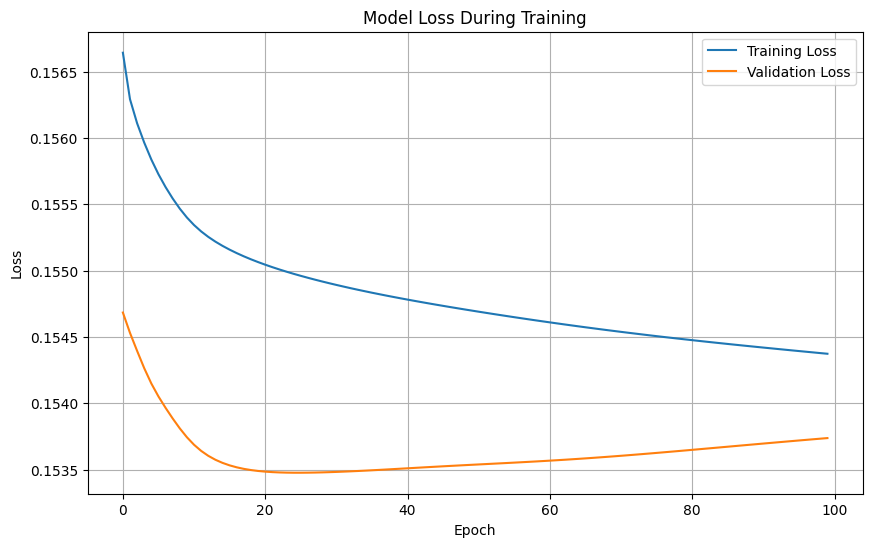

In [20]:
# Create checkpoint callback
import os
if not os.path.exists('./Networks'):
    os.makedirs('./Networks')

checkpoint_path = f'./Networks/LocalGLMnet_{seed}.weights.h5'
checkpoint = keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                           monitor='val_loss',
                                           save_best_only=True,
                                           save_weights_only=True)

# Compile model
model.compile(loss='poisson', optimizer='nadam')

# Train model
history = model.fit([X_learn, V_learn], Y_learn,
                   validation_split=0.1,
                   batch_size=5000,
                   epochs=100,
                   verbose=0,
                   callbacks=[checkpoint])

# Plot training history
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

### LocalGLMnet results

In [21]:
# Load best weights and evaluate
model.load_weights(checkpoint_path)
w1 = model.get_weights()
learn_nn = model.predict([X_learn, V_learn], batch_size=10**6, verbose=0)
test_nn = model.predict([X_test, V_test], batch_size=10**6, verbose=0)

print("Poisson Deviance GLM (Train, Test):", 
      round(100*mean_poisson_deviance(Y_learn/V_learn, learn_GLM/V_learn, sample_weight=V_learn), 3),
      round(100*mean_poisson_deviance(Y_test/V_test, test_GLM/V_test, sample_weight=V_test), 3))

print("Poisson Deviance LocalGLMnet (Train, Test):", 
      round(100*mean_poisson_deviance(Y_learn/V_learn, learn_nn/V_learn, sample_weight=V_learn), 3),
      round(100*mean_poisson_deviance(Y_test/V_test, test_nn/V_test, sample_weight=V_test), 3))



Poisson Deviance GLM (Train, Test): 45.759 45.634
Poisson Deviance LocalGLMnet (Train, Test): 44.994 45.034


### Illustrate the LocalGLMnet results: extract attention weights

In [22]:
# Create attention model
attention_model = keras.Model(inputs=model.input, outputs=model.get_layer('Attention').output)

# Get attention weights
attention_weights = attention_model.predict([X_test, V_test], batch_size=10**6)
attention_df = pd.DataFrame(attention_weights, columns=features)


# Scale attention weights
weights = model.get_weights()
attention_df = attention_df * weights[-2].flatten()[0]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


### Boxplot of the attention weights (RandNX is unrelated to the response)

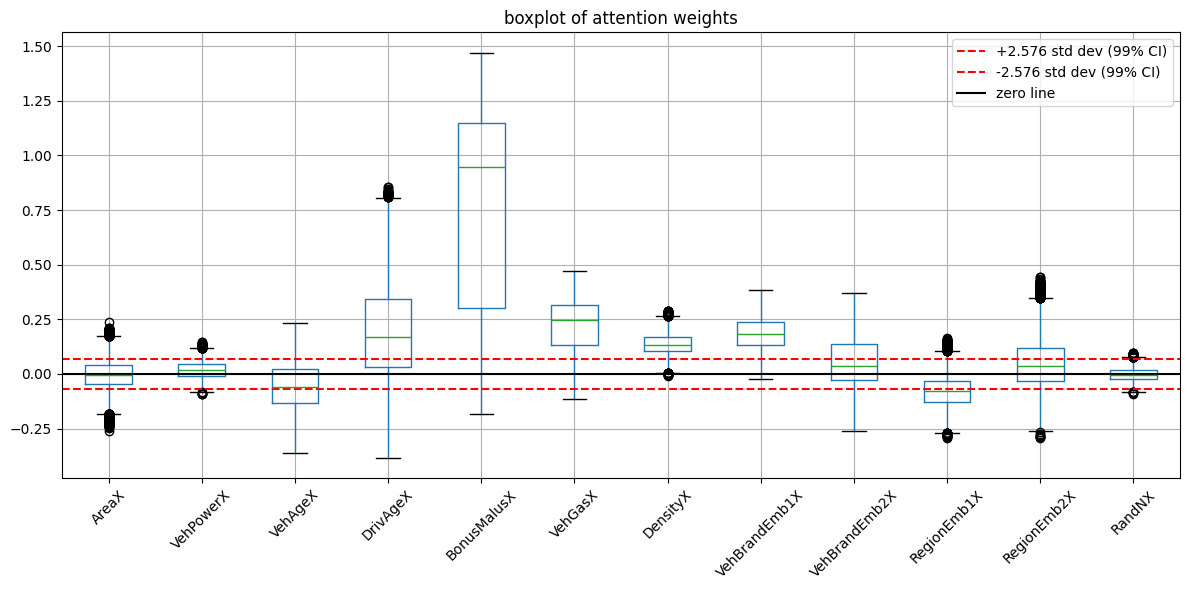

In [23]:
# Calculate standard deviation of RandNX (which does not impact the response) 
randnx_std = attention_df['RandNX'].std()
threshold = 2.576 * randnx_std

# Plot attention weights
plt.figure(figsize=(12, 6))
attention_df.boxplot()
plt.xticks(rotation=45)
plt.title('boxplot of attention weights')
plt.axhline(y=threshold, color='r', linestyle='--', label='+2.576 std dev (99% CI)')
plt.axhline(y=-threshold, color='r', linestyle='--', label='-2.576 std dev (99% CI)')
plt.axhline(y=0, color='k', linestyle='-', label='zero line')
plt.legend()
plt.tight_layout()
plt.show()

### Compute importance measure for all variables/terms

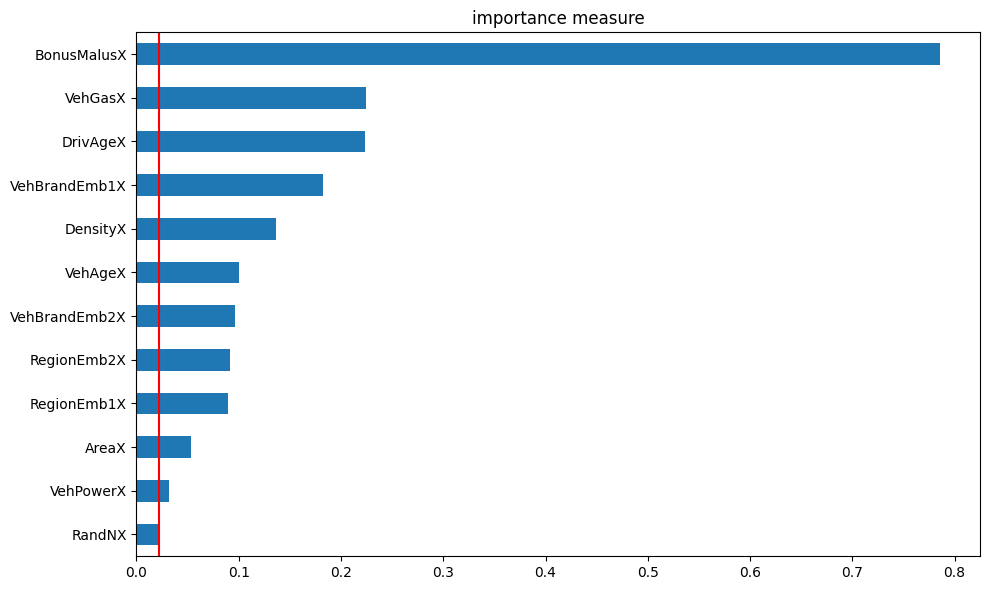

In [24]:
# Calculate importance measure
vi = np.abs(attention_df).mean()
vi = vi.sort_values()

# Plot importance measure
plt.figure(figsize=(10, 6))
vi.plot(kind='barh')
# Add vertical line for AreaX importance
area_importance = vi['RandNX']
plt.axvline(x=area_importance, color='red', linestyle='-', label='RandNX importance')
plt.title('importance measure')
plt.tight_layout()
plt.show()

### Plot individual attention weights for selected variables

In [25]:
# Function to create individual attention weight plots
def plot_attention_weights(feature_name, alpha):
    # Get unique values for x-axis
    x_values = np.sort(test[feature_name].unique())
    
    # Create the plot
    plt.figure(figsize=(10, 6))
    
    # Plot the attention weights
    plt.scatter(test[feature_name], attention_df[feature_name], 
                alpha=0.5, s=20, label='attention weights')
    
    # Add reference lines
    plt.axhline(y=0, color='cyan', linestyle='-', label='zero line')
    plt.axhline(y=0.674*randnx_std, color='orange', linestyle='-', label='0.674 std.dev. (50%)')
    plt.axhline(y=-0.674*randnx_std, color='orange', linestyle='-')
    plt.axhline(y=2.576*randnx_std, color='red', linestyle='-', label='2.576 std.dev. (99%)')
    plt.axhline(y=-2.576*randnx_std, color='red', linestyle='-')
    
    # Add shaded area
    plt.fill_between([test[feature_name].min(), test[feature_name].max()],
                     [-0.674*randnx_std, -0.674*randnx_std],
                     [0.674*randnx_std, 0.674*randnx_std],
                     color='orange', alpha=0.3)
    
    # Add local regression fit
    from statsmodels.nonparametric.smoothers_lowess import lowess
    
    # Sort the data for local regression
    sorted_indices =   np.argsort(test[feature_name])
    x_sorted = test[feature_name].iloc[sorted_indices]
    y_sorted = attention_df[feature_name].iloc[sorted_indices]
    
    # Fit local regression
    lowess_fit = lowess(y_sorted, x_sorted, frac=alpha, it=3)
    
    # Plot the local regression fit
    plt.plot(lowess_fit[:, 0], lowess_fit[:, 1], color='lightgreen', label='local regression fit')
    
    # Customize the plot
    plt.title(f'attention weights: {feature_name}', fontsize=14)
    plt.xlabel(feature_name, fontsize=12)
    plt.ylabel('attention weights', fontsize=12)
    plt.legend(loc='lower right')
    
    # Set y-axis limits
    #ylim0 = max(abs(attention_df[feature_name]))
    ylim0 = np.max(np.abs(attention_df))
    plt.ylim(-ylim0, ylim0)
    
    plt.tight_layout()
    plt.show()


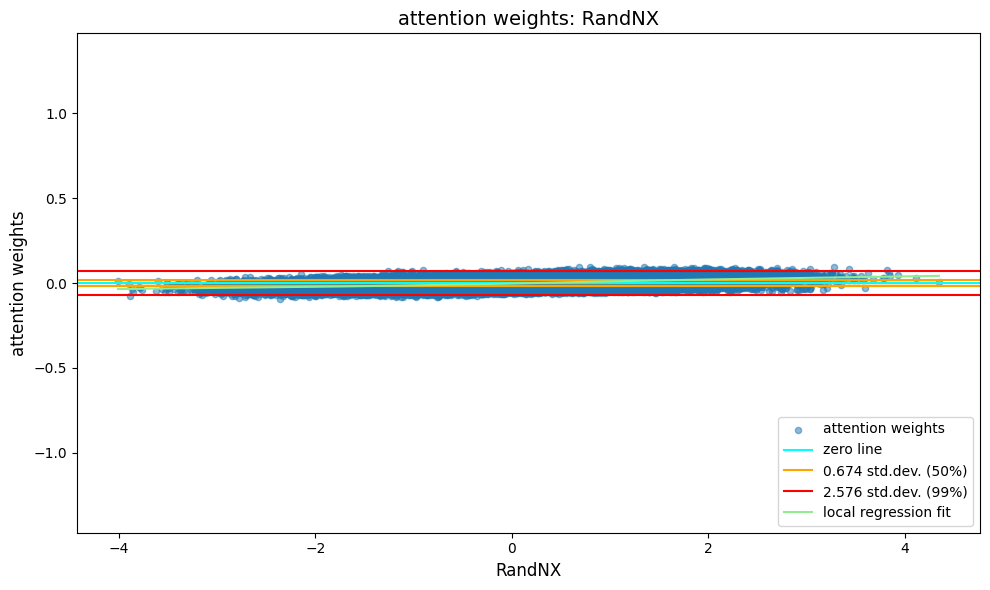

In [26]:
# This is the purely random variable not impacting the response
# we perform a local regression which is a bit time consuming
plot_attention_weights('RandNX', 0.3)

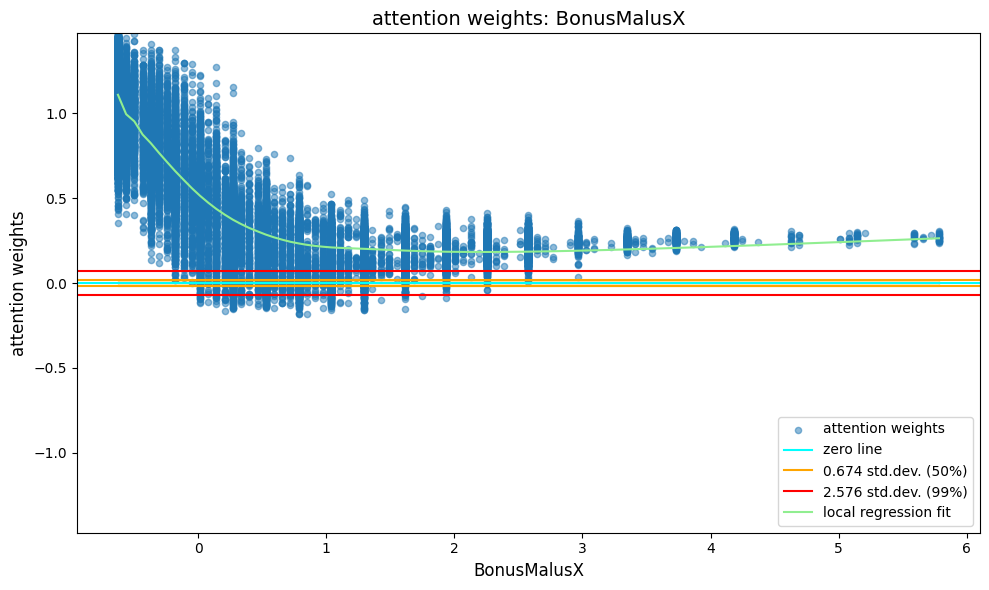

In [27]:
# BonusMalus is the most significant term
# the local regression is not fully sensible because BonusMalus values cluster at the lowest level
plot_attention_weights('BonusMalusX', 0.6)

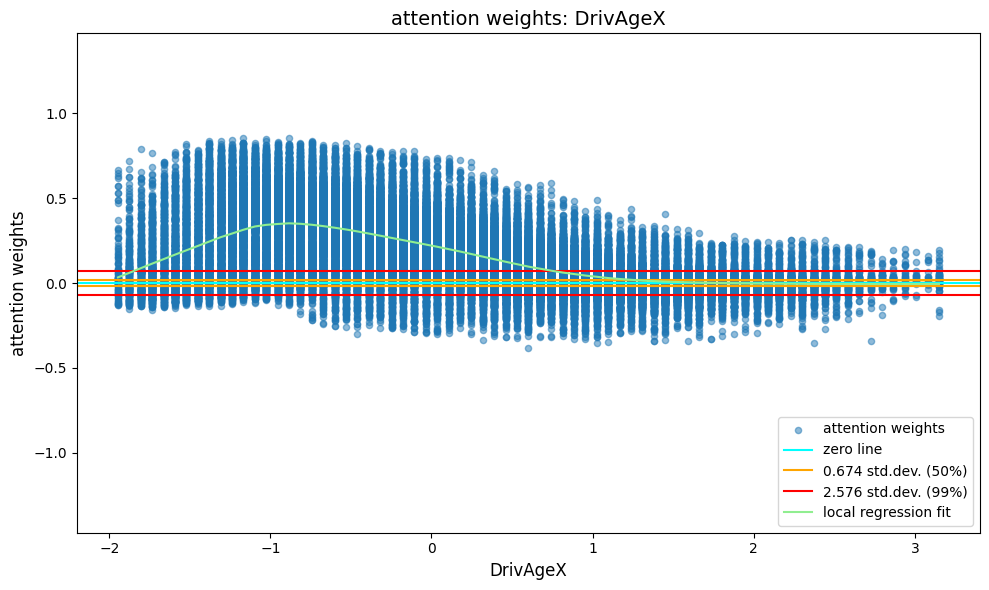

In [28]:
# Driver age variabel
plot_attention_weights('DrivAgeX', 0.3)